In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/'

Obtain the UVB grid from FG20

In [4]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [5]:
z_test = 1

In [6]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify grid points for densities

In [7]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

Load grids

In [63]:
col_thin_grid = np.loadtxt(rootdir+'HI_fraction/fixed_column/logN_HI=12/igm_lalpha_hm12_grid_1200.col')
col_thick_grid = np.loadtxt(rootdir+'HI_fraction/fixed_column/logN_HI=17/igm_lalpha_hm12_grid_1200.col')
size_grid = np.loadtxt(rootdir+'HI_fraction/fixed_size/igm_lalpha_hm12_grid_1200.col')

In [64]:
f_HI_col_thin = col_thin_grid[:,0]/(col_thin_grid[:,0]+col_thin_grid[:,1]+col_thin_grid[:,2])
f_HI_col_thick = col_thick_grid[:,0]/(col_thick_grid[:,0]+col_thick_grid[:,1]+col_thick_grid[:,2])
f_HI_size = size_grid[:,0]/(size_grid[:,0]+size_grid[:,1]+size_grid[:,2])

Text(0, 0.5, '$f_\\mathrm{HI}$')

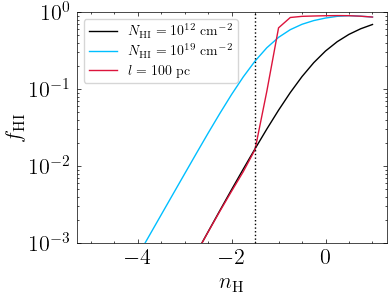

In [66]:
fig, ax = plt.subplots(1,figsize=(4,3))

ax.plot(log_hdens_arr, f_HI_col_thin, label='$N_\mathrm{HI}=10^{12} \ \mathrm{cm}^{-2}$')
ax.plot(log_hdens_arr, f_HI_col_thick, label='$N_\mathrm{HI}=10^{19} \ \mathrm{cm}^{-2}$')
ax.plot(log_hdens_arr, f_HI_size, label='$l=100 \ \mathrm{pc}$')

ax.axvline(-1.5, linestyle=':')

ax.legend(loc='upper left', fontsize=10)
ax.set_yscale('log')
ax.set_ylim(1e-3,1)
ax.set_xlabel(r'$n_\mathrm{H}$')
ax.set_ylabel(r'$f_\mathrm{HI}$')

In [50]:
L_thin = (col_thin_grid[:,0]+col_thin_grid[:,1]+col_thin_grid[:,2])/10**log_hdens_arr
L_thick = (col_thick_grid[:,0]+col_thick_grid[:,1]+col_thick_grid[:,2])/10**log_hdens_arr

Text(0, 0.5, '$L \\ (\\mathrm{pc})$')

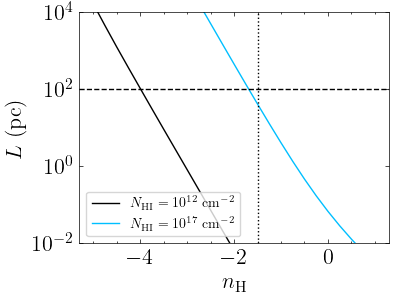

In [51]:
fig, ax = plt.subplots(1,figsize=(4,3))

ax.plot(log_hdens_arr, L_thin*3.24078e-19, label='$N_\mathrm{HI}=10^{12} \ \mathrm{cm}^{-2}$')
ax.plot(log_hdens_arr, L_thick*3.24078e-19, label='$N_\mathrm{HI}=10^{17} \ \mathrm{cm}^{-2}$')
ax.axhline(100, linestyle='--')

ax.axvline(-1.5, linestyle=':')

ax.legend(loc='lower left', fontsize=10)
ax.set_yscale('log')
ax.set_ylim(1e-2,1e4)
ax.set_xlabel(r'$n_\mathrm{H}$')
ax.set_ylabel(r'$L \ (\mathrm{pc})$')

In [60]:
ne_nH_thin = (col_thin_grid[:,3]/L_thin)/10**log_hdens_arr
ne_nH_thick = (col_thick_grid[:,3]/L_thick)/10**log_hdens_arr
ne_nH_size = (size_grid[:,3]/(100*3.086e+18))/10**log_hdens_arr

In [62]:
ne_nH_thin

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

HI neutral fraction

In [14]:
# Grid log logN_HI to plot
logN_HI_plot = [12,17]
# Reference metallicity
log_metals_test = -2.5
# Grid of densities to plot
log_hdens_plot = np.arange(-4, .5, .2)

# Grid of HI ion fractions
logf_HI_grid = np.zeros((len(logN_HI_plot),len(log_hdens_plot)))

# For each N_HI
for i in range(len(logN_HI_plot)):
    
    logN_HI = logN_HI_plot[i]
    
    # Grid of plot points
    plot_points = [[logN_HI, log_hdens, log_metals_test] for log_hdens in log_hdens_plot]
    
    # HII column density
    logN_HII = species_logN_interp['H+'](plot_points)
    
    # Total H column density
    logN_H = np.log10(10**logN_HI + 10**logN_HII)
    
    # Store log of ion fraction
    logf_HI_grid[i,:] = np.log10(10**logN_HI/10**logN_H)    

In [15]:
import matplotlib

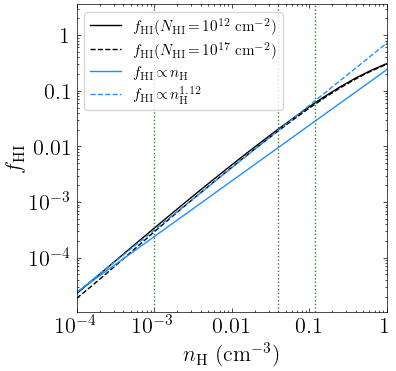

In [16]:
fig, ax = plt.subplots(1,figsize=(4,4))

ax.plot(10**log_hdens_plot,10**logf_HI_grid[0,:], label=r'$f_\mathrm{HI}(N_\mathrm{HI} \!=\! 10^{12} \ \mathrm{cm}^{-2})$',
        color='black')

ax.plot(10**log_hdens_plot,10**logf_HI_grid[1,:], label=r'$f_\mathrm{HI}(N_\mathrm{HI} \!=\! 10^{17} \ \mathrm{cm}^{-2})$',
        color='black', linestyle='--')

ax.plot(10**log_hdens_plot, (10**log_hdens_plot)/4.2, color='dodgerblue', label=r'$f_\mathrm{HI}\!\propto\!n_\mathrm{H}$')
ax.plot(10**log_hdens_plot, (10**log_hdens_plot)**1.12/1.4, color='dodgerblue', label=r'$f_\mathrm{HI}\!\propto\!n_\mathrm{H}^{1.12}$',
        linestyle='--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1)
ax.legend(fontsize=11)

ax.set_xlabel(r'$n_\mathrm{H} \ (\mathrm{cm}^{-3})$')
ax.set_ylabel(r'$f_\mathrm{HI}$')

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1],
    [r'$10^{-4}$', r'$10^{-3}$', r'$0.01$', r'$0.1$', r'$1$'])

ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1],
    [r'$10^{-4}$', r'$10^{-3}$', r'$0.01$', r'$0.1$', r'$1$'])

ax.axvline(0.04, color='forestgreen', linestyle=':')
ax.axvline(0.12, color='forestgreen', linestyle=':')
ax.axvline(1e-3, color='forestgreen', linestyle=':')

plt.savefig('/Users/thepoetoftwilight/Desktop/f_HI.png', dpi=300)